## Project: Creating Customer Segments

A wholesale distributor recently tested a change to their delivery method for some customers, by moving from a morning delivery service five days a week to a cheaper evening delivery service three days a week. Initial testing did not discover any significant unsatisfactory results, so they implemented the cheaper option for all customers. Almost immediately, the distributor began getting complaints about the delivery service change and customers were canceling deliveries — losing the distributor more money than what was being saved. We’ve been hired by the wholesale distributor to find what types of customers they have to help them make better, more informed business decisions in the future. Our task is to use unsupervised learning techniques to see if any similarities exist between customers, and how to best segment customers into distinct categories.

## Getting Started

In this project, we will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Let's run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. We will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, we will begin exploring the data through visualizations and code to understand how each feature is related to the others. We will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which we will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products we could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [3]:
# Select three indices of your choice you wish to sample from the dataset
indices = [0, 35, 47]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,688,5491,11091,833,4239,436
2,44466,54259,55571,7782,24171,6465


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for our sample customers.  

* What kind of establishment (customer) could each of the three samples we've chosen represent?

Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others.

In [4]:
percentile_of_data = 100*data.rank(pct = True).round(decimals=3)
percentile_of_samples = percentile_of_data.loc[indices]
percentile_of_samples

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,66.4,83.9,65.0,7.5,68.2,63.0
35,8.6,65.2,77.0,29.1,77.5,26.9
47,97.7,99.8,99.3,90.5,99.1,98.4


**Answer:**
- Sample 1 (Index 0) has annual spending on milk in the 80th percentile and annual spending on Fresh produce, Grocery, Detergents_Paper, and Delicatessen in the 60th percentile. This customer has very low spending on Frozen products. It is very likely that food is made fresh here and this customer is a restaurant. 
- Sample 2 (Index 35) has above-median spending on Milk, Grocery, and Detergents_Paper (65.2, 77.0, AND 77.5 percentile respectively). The spending on Fresh produce is low (8.6 percentile). This customer is more likely a cafe or bakery.
- Sample 3 (Index 47) has very high annual spending on all the categories that are in the 90th percentile. This customer is very likely a wholesale retailer.

Also, when I compare Sample 1, Sample 2, and Sample 3 along with the mean annual spending for all customers. It looks like Sample 1 and Sample 2 are small outlets, whereas Sample 3 is a wholesale retailer.

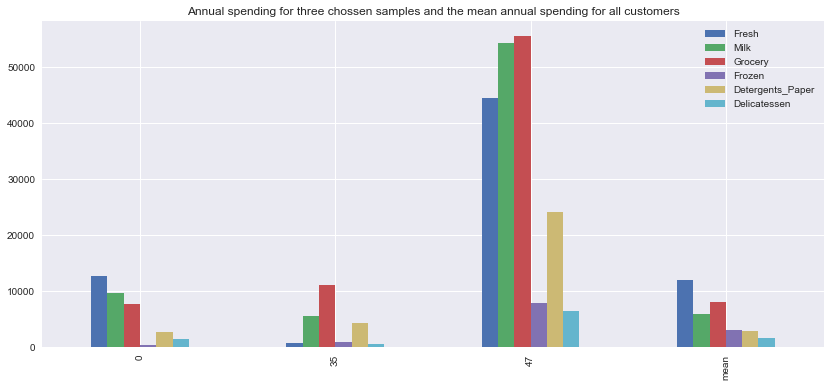

In [7]:
# Calculate the mean spending of entire customer in each category and append it to the samples dataframe
samples_bar = samples.append(data.describe().loc['mean'])
samples_bar.index = indices + ['mean']

# Plot the annual spending for three samples along with mean of the entire customers
samples_bar.plot(kind='bar', figsize=(14,6))
plt.title('Annual spending for three chossen samples and the mean annual spending for all customers');

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, we will implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [5]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.copy(deep=True)

grocery_raw = new_data['Grocery']
features_raw = new_data.drop(['Grocery'], axis = 1, inplace = True)

# Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Grocery'],
                                                   test_size=0.25, random_state=42)

# Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42)
model = regressor.fit(X_train, y_train)
predictions_test = regressor.predict(X_test)

# Report the score of the prediction using the testing set
from sklearn.metrics import r2_score
score = r2_score(y_test, predictions_test)

# Print the results 
print "Decision Tree Regressor model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Decision Tree Regressor model has a coefficient of determination, R^2, of 0.682.


### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score? 
* Is this feature necessary for identifying customers' spending habits?

**Answer:**
- I attempted to predict Grocery.
- The reported prediction score ($R^2$) of the model was 0.682. $R^2$, the coefficient of determination, represents the goodness of fit of predictions to the actual value. $R^2$ is scored between 0 and 1, with 0 being no fit and 1 being a perfect fit. A negative $R^2$ implies the model fails to fit the data. 
- Grocery is predictable, since the R2 score is a significant positive score (within 0 and 1). This means that the grocery feature can be predicted by other features. The feature may not be necessary for identifying customers' spending habits if other correlated features are already presented. Highly correlated features offer little training value as the presence/state of one can infer the presence/state of another. For instance, if feature A "on" equals to feature B "on" then all the states can be inferred by either learning A or B. In contrast, a low score on the feature implies that this feature is hard to predict using other features which makes it an important feature to consider when considering relevance.[Ref](https://datascience.stackexchange.com/questions/12259/feature-redundancy)

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If we found that the feature we attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if we believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

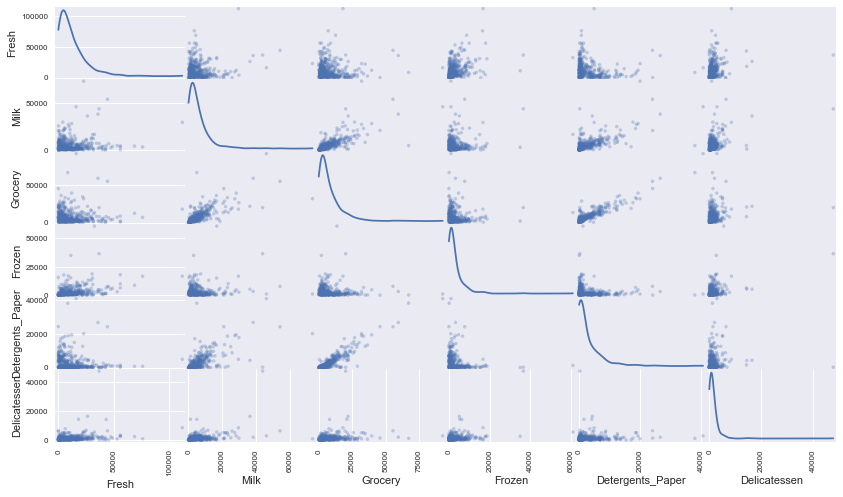

In [6]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to separate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?

**Answer:**
- The distribution of all the features in the dataset are positively skewed. There is an elongated tail at the right and more data in the right tail than would be expected in a normal distribution. The distribution can also be described as log-normal, since applying a natural logarithm scaling to the data will make the features appear much more normal. There is also a large number of points near zero suggesting a majority of customers are small outlets. 
- There are three pairs of features which have a correlation coefficient (R) above 0.5. Grocery exhibits a high degree of correlation with Detergents_Paper (0.92) and the moderate degree of correlation with Milk (0.73). Milk and Detergents_Paper also exhibit moderate correlation with a correlation coefficient (R) of 0.66.
- This does confirm my suspicion that Grocery feature is not relevant for identifying a specific customer. It has a high linear correlation (0.92) with Detergents_Paper and the relationship can be described using linear regression equation.
- Data for Grocery and Detergents_Paper are positively skewed.

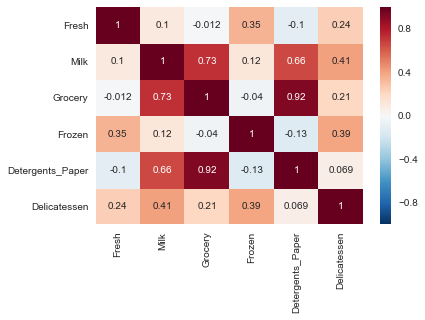

In [7]:
ax = sns.heatmap(data.corr(), annot=True)

## Data Preprocessing
In this section, we will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results we obtain from our analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, we will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. 
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. 

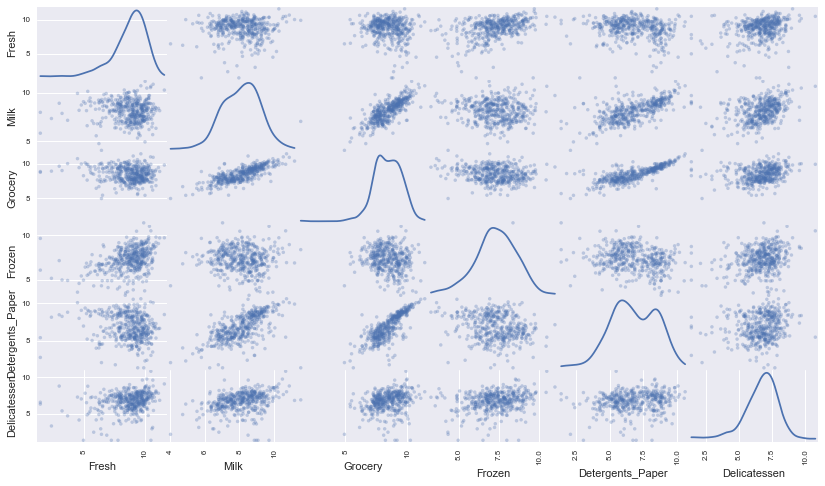

In [8]:
# TODO: Scale the data using the natural logarithm
log_data = data.apply(lambda x: np.log(x + 1))

# TODO: Scale the sample data using the natural logarithm
log_samples = samples.apply(lambda x: np.log(x + 1))

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature appear much more normal. 
Let's run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [9]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678
1,6.535241,8.611048,9.313979,6.726233,8.352319,6.079933
2,10.702503,10.901543,10.925435,8.959697,10.092950,8.774313


For any pairs of features we may have identified earlier as being correlated, let's observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

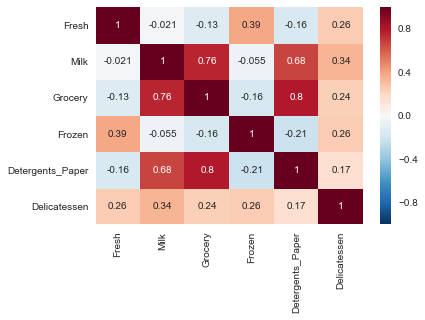

In [10]:
ax = sns.heatmap(log_data.corr(), annot=True)

The three strongest correlation we have identified earlier exists even after logarithmic transformation.

|     Feature pair     |    R Before log transformation | R After log transformation | 
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Grocery and Detergents_Paper   | 0.92              | 0.8           | 
| Grocery and Milk    | 0.73            | 0.76           | 
| Milk and Detergents_Paper    | 0.66              | 0.68          | 

### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identifying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the plot below, outliers are the points outside box and whisker.

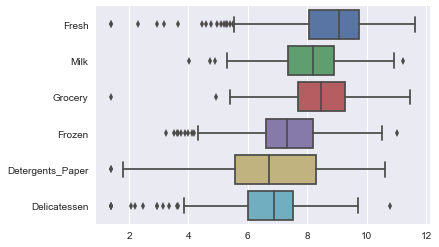

In [11]:
sns.boxplot(data=log_data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']], orient = "h");

In the code block below, we will implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.

In [12]:
# Initiate an empty list to store all outliers
outliers  = []

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25.0)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75.0)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3 - Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    outliers_data_point = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(outliers_data_point)
    
    # Select the indices for data points you wish to remove
    outliers  += outliers_data_point.index.tolist()

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.454347,9.950371,10.732672,3.610918,10.095429,7.261225
66,2.302585,7.336286,8.911665,5.170484,8.151622,3.332205
81,5.393628,9.163354,9.575261,5.648974,8.964312,5.056246
95,1.386294,7.979681,8.740817,6.089045,5.411646,6.565265
96,3.178054,7.869784,9.001962,4.983607,8.262301,5.384495
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294
171,5.303305,10.160569,9.894295,6.480045,9.079548,8.740497
193,5.198497,8.156510,9.918031,6.866933,8.633909,6.502790
218,2.944439,8.923325,9.629445,7.159292,8.475954,8.759826
304,5.087596,8.917445,10.117550,6.426488,9.374498,7.787797


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.040027,11.205027,10.377078,6.895683,9.907031,6.806829
98,6.222576,4.727388,6.658011,6.797940,4.043051,4.890349
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225
356,10.029547,4.905275,5.389072,8.057694,2.302585,6.308098


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.432071,9.663325,9.723763,3.526361,8.847504,6.073045
57,8.597482,9.203718,9.257987,3.663562,8.932345,7.156956
65,4.454347,9.950371,10.732672,3.610918,10.095429,7.261225
145,10.000614,9.034200,10.457171,3.761200,9.440817,8.396381
175,7.759614,8.967759,9.382191,3.970292,8.342125,7.437206
264,6.979145,9.177817,9.645105,4.127134,8.696343,7.143618
325,10.395681,9.728241,9.519808,11.016496,7.149132,8.632306
420,8.402231,8.569216,9.490091,3.258097,8.827468,7.239933
429,9.060447,7.467942,8.183397,3.871201,4.442651,7.824846
439,7.933080,7.437795,7.828436,4.189655,6.169611,3.970292


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463
161,9.428270,6.293419,5.648974,6.996681,1.386294,7.711549


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.302585,7.336286,8.911665,5.170484,8.151622,3.332205
109,7.249215,9.724959,10.274603,6.513230,6.729824,1.386294
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294
137,8.035279,8.997271,9.021961,6.495266,6.582025,3.610918
142,10.519673,8.875287,9.018453,8.005033,3.044522,1.386294
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225
183,10.514557,10.690831,9.912001,10.506026,5.480639,10.777789
184,5.793014,6.823286,8.457655,4.317488,5.814131,2.484907
187,7.799343,8.987572,9.192176,8.743532,8.149024,1.386294
203,6.369901,6.530878,7.703910,6.152733,6.861711,2.944439


Here we find 42 outliers, in 440 samples, nearly 10 percentage of the total number. If we remove all the outlier, we would lose a lot of information. In this case, we will check if there are samples that are considered outliers for more than one feature.

### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.

** Hint: ** If we have datapoints that are outliers in multiple categories think about why that may be and if they warrant removal. Also note how k-means is affected by outliers and whether or not this plays a factor in our analysis of whether or not to remove them.

In [13]:
from collections import Counter 
# Count the occurence of each index
c = Counter(outliers)

outliers_to_remove = []
# Find data points considered outliers for more than one feature
print "The data points considered outliers for more than one feature and their counts are:"
for index, count in c.iteritems():
    if count > 1:
        outliers_to_remove.append(index)
        print (index, count)

The data points considered outliers for more than one feature and their counts are:
(128, 2)
(154, 3)
(65, 2)
(66, 2)
(75, 2)


**Answer:** Inspired from this [post](https://stats.stackexchange.com/questions/214362/trouble-in-understanding-outliers-influence-on-k-means).
- There are five data points considered outliers for more than one feature. For instance, data point 65 is considered outlier for both Fresh and Frozen features.
- Yes, based on Tukey's method these data points are outliers for more than one feature and it is reasonable to remove them.
- the k-means algorithm is very sensitive to outliers. 
    - k-means clustering operates in two steps - assign and optimize. 
    - In the assignment step, we randomly assign k-cluster centers and assign each data point to the closest cluster center (in the Euclidean distance).
    - In the optimization step, we replace each cluster center by the coordinate-wise average of all data points
that are closest to it. 
    - We repeat this two steps until the total within-cluster variation summed over all k clusters is as small as possible.
    - Let's image we have two nice clusters- Gaussian point clouds. a k-means algorithm with k=2 will find two true centers that are the best representative configuration.
    - Let's now introduce an outlier in the data point that is way off than either of the true clusters are to each other. 
    - Now in order to minimize the loss function, k-means will assign the outlier itself as one center and place the other center in the middle of remaining data. These centers are obviously not the true representation of the underlying distribution.

Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If we choose to remove any outliers, we have to ensure that the sample data does not contain any of these points!  
Once we have performed this implementation, the dataset will be stored in the variable `good_data`.

In [14]:
# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers_to_remove]).reset_index(drop = True)

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, we will implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

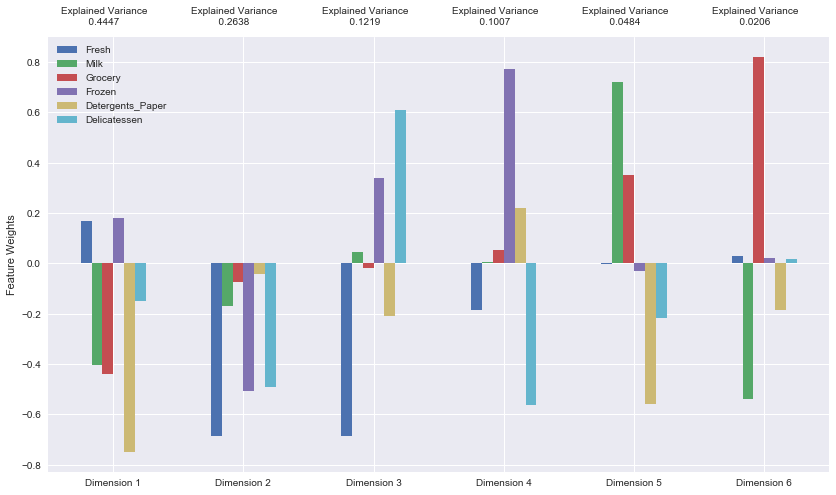

In [15]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(random_state = 42)
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.

In [16]:
print "The cumulative variance explained are {}".format((pca.explained_variance_ratio_).cumsum())

The cumulative variance explained are [ 0.44465231  0.70849803  0.83034918  0.93108785  0.97944545  1.        ]


**Answer:**
- The total variance explained by first two principal components are 72.542%.
- The total variance explained by first two principal components are 92.808%.
- Each principal component assigns different weight to all the features.
    - 1) The first principal component (PC1) is the normalized linear combination of all the features that have the largest variance. Normalized here means that the sum of square of the feature weights is one. In our case, the first principal component represents a line in six-dimensional space that is closest to n (= total number of good_data) observations. A large weight in any direction (positive or negative) will indicate a higher purchase value for the feature. Similarly, a small feature weight in any direction (positive or negative) indicates that the customer buys lesser from this feature. Hence, PC1 best represents customer spending in Detergents_Paper, Grocery, and Milk.
    - 2) The second principal component (PC2) is the linear combination of all the features that have maximal variance out of all the linear combinations that are uncorrelated with PC1. PC2 best represents customer spending in Fresh, Frozen, and Delicatessen.
    - 3) PC3 represents customer spending mainly in Fresh, Detegrents_Paper, and Frozen. If two features are opposite in sign in a given dimension, means that they are inversely correlated - spending on one increases as that on the other decreases. Features Fresh is inversely correlated to Detegrents_Paper and Frozen in thirs dimension.
    - 4) PC4 represents customer spending mainly in Frozen and Delicatessen.

Reference - Interpretation of [PCA](http://setosa.io/ev/principal-component-analysis/) and [PCs](https://onlinecourses.science.psu.edu/stat505/node/54).

### Observation
Let's run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with our initial interpretation of the sample points.

In [17]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-1.7539,0.0192,-1.0117,-1.6474,0.2619,-0.3895
1,-2.1222,1.9238,0.6317,0.6919,-0.0575,0.0676
2,-4.3553,-3.9595,-0.1059,0.6023,0.5205,0.0516


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

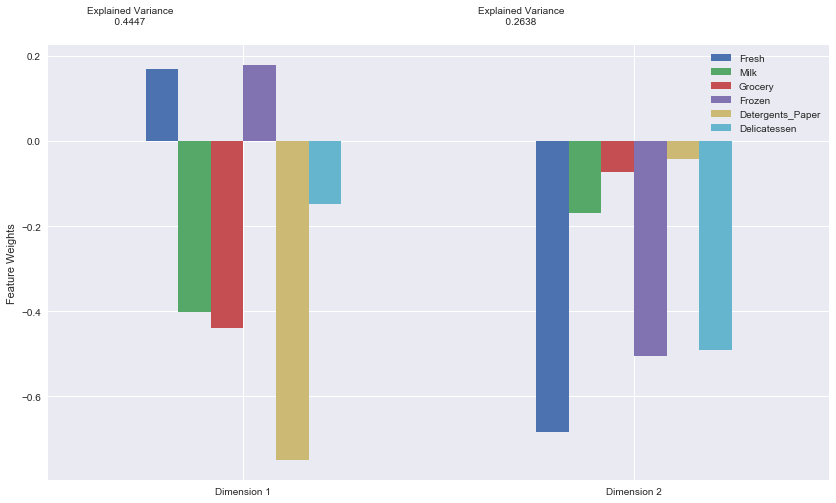

In [18]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

# Generate PCA results plot with only two dimensions
pca_results2 = vs.pca_results(good_data, pca)

### Observation
Let's run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. We can observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [19]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-1.7539,0.0192
1,-2.1222,1.9238
2,-4.3553,-3.9595


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Let's run the code cell below to produce a biplot of the reduced-dimension data.

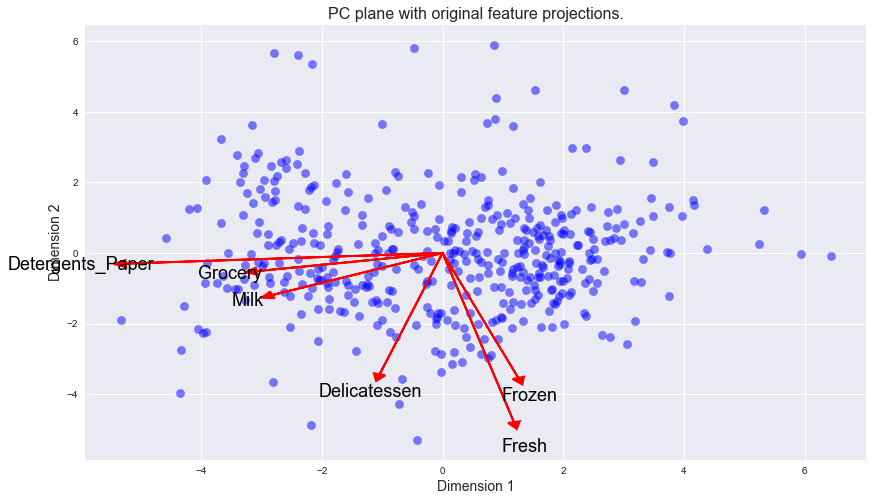

In [20]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca);

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot we obtained earlier?

## Clustering

In this section, we will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. We will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

** Hint: ** Think about the differences between hard clustering and soft clustering and which would be appropriate for our dataset.

**Answer:**
Answer inspired from following posts [1](https://www.quora.com/What-are-the-advantages-of-K-Means-clustering), [2](https://www.quora.com/What-is-the-difference-between-K-means-and-the-mixture-model-of-Gaussian) and [3](https://stats.stackexchange.com/questions/89229/run-time-analysis-of-the-clustering-algorithm-k-means).

**K-means clustering algorithm**
- _Advantages_
    - 1) Simple and easy to implement.
    - 2) Clustering results are easy to interpret.
    - 3) Faster and more scalable- the time complexity of the Lloyds algorithm for k-means clustering is O(n*K*I*d) where n = number of data points, K = number of clusters, I = number of iterations, and d = number of attributes.
    - 4) Well-suited for situations with lots of data where the clusters are clearly separable.
- _Disadvantages_
    - 1) Hard assignment of data points - the data point rigidly belongs to one cluster or another.
    - 2) Cannot find non-convex cluster or cluster with complex geometrical shapes.
    - 3) Sensitive to outliers.
    - 4) The problem of finding global optimum for k-means algorithm is NP-hard because there are almost $K^n$ ways to partition n observations into K clusters. So, the standard K-means algorithm finds local rather than the global optimum. 
     - 5) Since the algorithm finds local optimum there is no unique solution for certain K value. The local optimum depends on the initial random cluster center assignment. It is important to run the algorithm multiple times with different random initial cluster center and select the one that minimizes total within-cluster variation.
     
**Gaussian Mixture Model (GMM)**
- _Advantages_   
    - 1) Soft assignment of data points to a cluster. The model is not forced to assign data points to one cluster or another, instead, it can be probabilistically from one of the multiple possible clusters. It gives the probability of belonging to one cluster or another. Even if an object has a really high probability of belonging to one cluster let's say 0.995, it still has 0.005 probability of belonging to another cluster. Conversely, if a point has very very low probability i.e it is very very far away from the center of Gaussian, it still has a chance of being generated by that Gaussian.
    - 2) Does not assume cluster to be of any geometry. Not biased toward detecting only spherical cluster like K-means. 
    - 3) GMM finds k to minimize $\frac{(x - \mu_k)^2}{\sigma^2}$, takes variance into consideration. K-means finds k to minimize $(x - \mu_k)^2$
- _Disadvantages_   
    - 1) Has more parameters, so initialization of the clusters will be difficult when the dimensionality of data is high.
    - 2) Difficult to interpret.
    - 3) Similar to K-means, it is also susceptible to local optimum, so reinitializing at several different initial parameters is a good approach. 

**Preference of one algorithm over another**
<br>
In the above biplot, there is no clear separation of the data into clusters. A lot of data point doesn't clearly belong to one cluster or another. In addition, after PCA we are left with two dimensions. The dimensionality of the data is not very high. The probabilistic GMM model will be more appropriate in this case. 

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, we will implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [21]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

def gmm(n_components):
    global clusterer, preds, centers, sample_preds
    
    # Apply clustering algorithm of our choice to the reduced data 
    gmm = GaussianMixture(n_components, random_state = 42)
    clusterer = gmm.fit(reduced_data)
    
    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    
    return score

In [22]:
n_components_range = range(2, 10)
scores = []
for n_components in n_components_range:
    scores.append(gmm(n_components))

display(pd.DataFrame({'No. of clusters':n_components_range, 
                    'Silhouette score': scores}))

,No. of clusters,Silhouette score
0,2,0.423635
1,3,0.403806
2,4,0.303696
3,5,0.192906
4,6,0.265186
5,7,0.344624
6,8,0.304771
7,9,0.301247


### Question 7

* Report the silhouette score for several cluster numbers tried. 
* Of these, which number of clusters has the best silhouette score?

**Answer:**
- The silhouette score for several cluster numbers are reported above.
- Gaussian mixture model with two clusters gave the best silhouette score.

### Cluster Visualization
Once we've chosen the optimal number of clusters for our clustering algorithm using the scoring metric above, we can now visualize the results by executing the code block below.

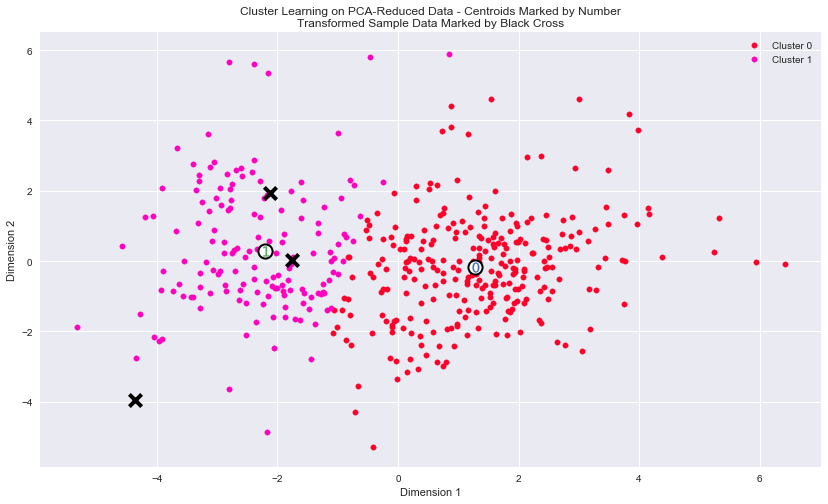

In [23]:
# Display the results of the clustering from implementation
gmm(2)

vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, we will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.

In [24]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8914.0,2086.0,2729.0,2074.0,349.0,727.0
Segment 1,3659.0,7845.0,12181.0,889.0,4636.0,982.0


### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project (specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`. Think about what each segment represents in terms their values for the feature points chosen. Reference these values with the mean values to get some perspective into what kind of establishment they represent.

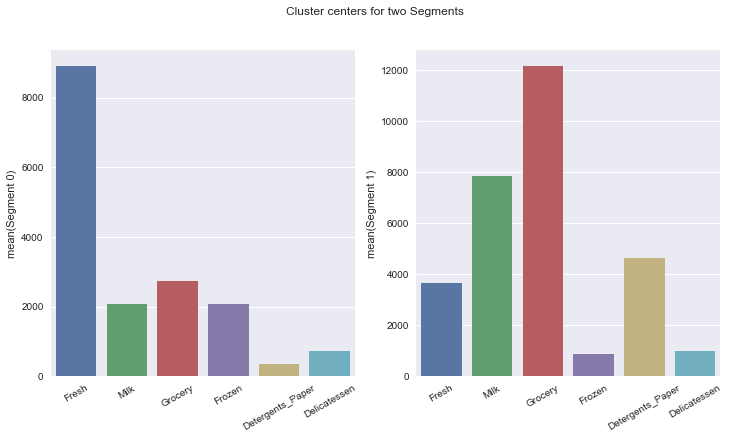

In [52]:
fig, ax = plt.subplots(ncols=2, figsize = (12,6))
p1 = sns.barplot(x = true_centers.columns.values, y = true_centers.loc['Segment 0'], ax = ax[0])
p2 = sns.barplot(x = true_centers.columns.values, y = true_centers.loc['Segment 1'], ax = ax[1])
p1.set_xticklabels(true_centers.columns.values, rotation=30)
p2.set_xticklabels(true_centers.columns.values, rotation=30)
fig.suptitle('Cluster centers for two Segments');

**Answer:**
The average spending of the overall customers are:

|     Fresh    |  Milk  | Grocery |  Frozen  |  Detergents_Paper  |  Delicatessen  |
| :------------: | :-----------------: | :---------------: | :-------------: | :-------------: | :-------------: | 
| 12000.297727  | 5796.265909    | 7951.277273   | 3071.931818 |2881.493182 |1524.870455|
					
Segment 0 has high average spending on Fresh category followed by Grocery, Frozen, and Milk. However, the average spending of Segment 0 on all categories is below the average spending of all the customers. This segment most likely represents Restaurants/Cafes serving fresh food.

Segment 1 has high average spending Grocery followed by Milk, Detergents_Paper, and Fresh. The average spending of this segment on Milk, Grocery, Detergents_Paper is higher than average spending of all the customers. This segment most likely represents Wholesale Retailer.

In the plot below, I show the distribution of customer spending for `Segment 0` and `Segment 1` in the original untransformed data.

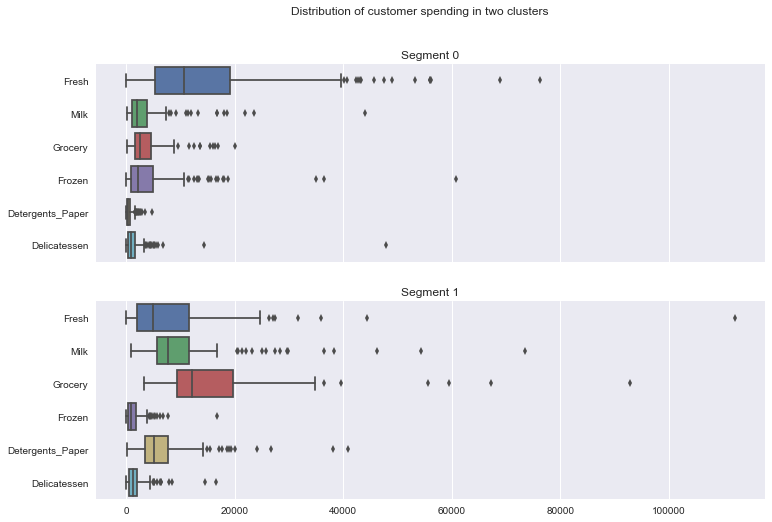

In [50]:
# Retrieve the original data minus outliers without log transformation
good_data_no_log = data.drop(data.index[outliers_to_remove]).reset_index(drop = True)

# Plot the distribution of customer spending for Segment 0 and Segment 1
fig, ax = plt.subplots(nrows=2, sharex = True, figsize = (12,8))
segment0 = sns.boxplot(data = good_data_no_log[['Fresh', 'Milk', 'Grocery', 'Frozen', 
                                                'Detergents_Paper', 'Delicatessen']]
                       [preds == 0],
                       orient = "h",
                       ax = ax[0])
segment1 = sns.boxplot(data = good_data_no_log[['Fresh', 'Milk', 'Grocery', 'Frozen', 
                                                'Detergents_Paper', 'Delicatessen']]
                       [preds == 1], 
                       orient = "h",
                       ax = ax[1])
ax[0].set_title('Segment 0')
ax[1].set_title('Segment 1')
fig.suptitle('Distribution of customer spending in two clusters');

### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

Let's run the code block below to find which cluster each sample point is predicted to be.

In [26]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1


**Answer:**
- Sample point 0 (Index 0): 
    - Initial guess: Restaurant
    - Model prediction: Wholesale Retailer
- Sample point 1 (Index 35): 
    - Initial guess: Cafe/Bakery
    - Model prediction: Wholesale Retailer
- Sample point 2 (Index 47): Wholesale Retailer
    - Initial guess: Wholesale Retailer
    - Model prediction: Wholesale Retailer
    
The predictions are not consistent other than for Sample point 2 (Index 47). The clustering takes all the data points into account and is a more general representation of sub-groups in the data. Customers with high spending on Fresh products and lower spending on other categories are grouped in Segment 0. Customers with overall higher spending are grouped in Segment 1.

In [27]:
# The three sample point selected in the beginning
display(samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,688,5491,11091,833,4239,436
2,44466,54259,55571,7782,24171,6465


## Conclusion

In this final section, we will investigate ways that we can make use of the clustered data. First, we will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, we will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, we will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Answer:**
- 1) The clustering model has revealed two different customer segments - Segment 0 (Restaurants/Cafes) and Segment 1 (Wholesale Retailer).
- 2) The hypothesis here is that Segment 1 stocks up on a wide variety of goods and might be okay with 3 days a week delivery service. In contrast, Segment 0 requires the regular supply of fresh food in order to run their business smoothly. This segment will not react positively to 3 days a week delivery service. We launch the experiment in Segment 1.

**Experimental Design**
- For segment 1 we will select a fraction of customers as experiment group and change the delivery scheme from 5 days a week to 3 days a week. For the rest of customers, we will keep 5 days a week delivery schedule. We will keep track of weekly spending of each customer in control and experiment group.

**Metrics**
- Weekly customer spending in control and experiment group before and after the experiment was launched.

**Results to look for inorder to launch the experiment**
- 1) No change in weekly customer spending for the duration of the experiment in Segment 1 for the control group.
- 2) No change in weekly customer spending for the duration of the experiment in Segment 1 for the experiment group.

**Number of customers in experiment group and duration of experiment**
This will depend on the Statistical power we want for the experiment. How much False positive and False negatives do we want to tolerate and the minimum detectable change boundaries? Also, since the experiment is a risky want, we don't want to split half the customers into experiment group.

**Other factors to keep in account**
If the experiment has to be launched for long periods of time, we have to keep months into account. Customers spending on festive months might be higher than a non-festive month. We are keeping track of changes before and after the experiment was launched so we have to ensure that customer spending on those times are comparable.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Answer:**
<br>
Now we have a target variable - customer segments (Segment 0 or Segment 1) and features - six different product categories for each customer. We can train a supervised classification algorithm and use the algorithm to label the new customers using only their estimated product spending.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Let's run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, we will find the sample points are circled in the plot, which will identify their labeling.

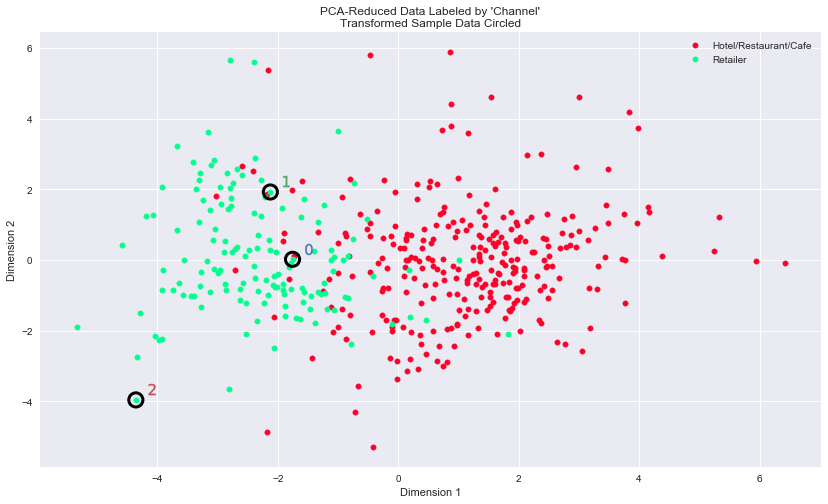

In [28]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers_to_remove, pca_samples)

### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**
- The clusters we have chosen based on Generalised linear model seem to correlate well with the actual distribution of Hotel/Restaurant/Cafe customers and Retailer customers. The actual distribution has, however, less defined separation of segments. Some customers in the boundary between two clusters have been misclassified. This could be because the spending pattern of big 'Hotels/Restaurants/Cafes' might overlap with spending pattern of small 'Retailers'. In addition, some Retailers lying in Hotel/Restaurant/Cafe region and some Hotel/Restaurant/Cafe owners lying in the Retail region have been misclassified by the model.
- Yes, there are customer segments that can be classified purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution.
- Yes, these classifications are consistent with the previous definition of the customer segments.

## References

- 1) [Machine Learning Nanodegree](https://www.udacity.com/course/machine-learning-engineer-nanodegree--nd009)
- 2) [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)